In [9]:
from utils.gaussian_viewing_utils import * 
import matplotlib.pyplot as plt
import os
from moviepy.editor import ImageSequenceClip

In [10]:
!nvidia-smi

Fri Nov 10 16:36:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   32C    P0    59W / 400W |  36609MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [11]:
!export CUDA_VISIBLE_DEVICES=1

In [12]:
model_path = '/raid/scratch_not_backed_up/sbonilla/seq3-1000-2000-subsampd/output/261f825b-7'
image_path = '/raid/scratch_not_backed_up/sbonilla/seq3-processed/output/39520b51-6'

# normal path 

# output path 

In [18]:
output_path = '/raid/scratch_not_backed_up/sbonilla/seq3-1000-2000-subsampd/output/261f825b-7/visualization/seq3-20-used-cams.mp4'
center_camera_idx = 50

num_views = 120
tilt_angle = 0.0001
fps = 20

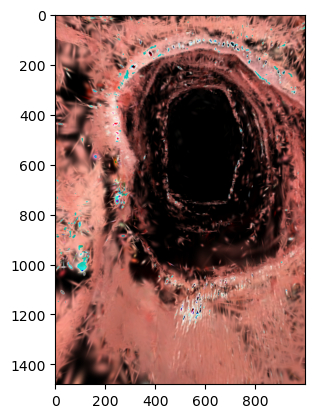

In [19]:
img_array = render_mask_gaussians(model_path, percent_of_gaussians=0.6, camera_index=20)
img = Image.fromarray(img_array, 'RGB')
plt.imshow(img)

In [23]:
images = []
max_cams = 20
for i in range(max_cams):
    img_array = render_mask_gaussians(model_path, percent_of_gaussians=i/max_cams, camera_index=i)
    images.append(img_array)

In [24]:
# create video from all frames in full_path using moviepy
clip = ImageSequenceClip(images, fps=5)
clip.write_videofile(output_path, codec='libx264', audio=False)
print(f'Video saved to {output_path}')

t:  10%|▉         | 2/21 [02:10<20:41, 65.32s/it, now=None]

Moviepy - Building video /raid/scratch_not_backed_up/sbonilla/seq3-1000-2000-subsampd/output/261f825b-7/visualization/seq3-20-used-cams.mp4.
Moviepy - Writing video /raid/scratch_not_backed_up/sbonilla/seq3-1000-2000-subsampd/output/261f825b-7/visualization/seq3-20-used-cams.mp4



t:  10%|▉         | 2/21 [02:11<20:51, 65.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /raid/scratch_not_backed_up/sbonilla/seq3-1000-2000-subsampd/output/261f825b-7/visualization/seq3-20-used-cams.mp4
Video saved to /raid/scratch_not_backed_up/sbonilla/seq3-1000-2000-subsampd/output/261f825b-7/visualization/seq3-20-used-cams.mp4
